In [ ]:
from pathlib import Path

from seisnetinsight.config import GridParameters
from seisnetinsight.data import load_events, load_stations, load_swd_wells
from seisnetinsight.grids import (
    compute_composite_index,
    compute_gap_grid,
    compute_subject_grids,
    compute_swd_grid,
    generate_grid,
    merge_grids,
)
import pandas as pd

CACHE_DIR = Path("cache")
CACHE_DIR.mkdir(exist_ok=True)

def _cache_path(name: str) -> Path:
    return CACHE_DIR / f"{name}.parquet"

def load_or_compute(name: str, compute_fn, *, overwrite=False):
    path = _cache_path(name)
    if path.exists() and not overwrite:
        return pd.read_parquet(path)
    df = compute_fn()
    path.write_bytes(b"")  # ensure parent dir exists even if fn fails
    df.to_parquet(path, index=False)
    return df

In [ ]:
bna_path = Path("../sample_files/midland.bna")
bna_bytes = bna_path.read_bytes()

EVENTS_CSV = '../sample_files/events_sample.csv'
STATIONS_CSV = '../sample_files/texnet_stations_2025.csv'
SWD_CSV = '../sample_files/swd_wells_sample.csv'

SWD_COLUMN_MAP = {
    "latitude": "latitude_wgs84",
    "longitude": "longitude_wgs84",
    "volume": "SUM_injected_liquid_BBL",
}

PARAMS = GridParameters(
    lons=(-102.9, -100.4),
    lats=(30.5, 34.0),
    grid_step=0.01,
    subject_primary_radius_km=4.0,
    subject_primary_min_stations=1,
    subject_primary_weight=0.3,
    subject_secondary_radius_km=10.0,
    subject_secondary_min_stations=1,
    subject_secondary_weight=0.4,
    gap_search_km=40.0,
    gap_target_angle_deg=90.0,
    weight_gap=0.1,
    swd_radius_km=25.0,
    weight_swd=0.2,
    half_time_years=5.0,
)

# Grids

In [6]:
params = PARAMS
events_df, missing_events = load_events(EVENTS_CSV, warn=False)
stations_df, missing_stations = load_stations(STATIONS_CSV, warn=False)
swd_df, missing_swd = load_swd_wells(SWD_CSV, column_map=SWD_COLUMN_MAP, warn=False)

grid = generate_grid(params)

In [7]:
subject_df = load_or_compute(
    "subject",
    lambda: compute_subject_grids(events_df, stations_df, grid, params),
    overwrite=False,
)

In [8]:
gap_df = load_or_compute(
    "gap",
    lambda: compute_gap_grid(events_df, stations_df, grid, params),
    overwrite=False,
)

In [9]:
swd_grid = compute_swd_grid(swd_df, grid, params)
swd_grid = load_or_compute(
    "swd",
    lambda: compute_swd_grid(swd_df, grid, params),
    overwrite=False,
)

In [10]:
merged = merge_grids(subject_df, gap_df, swd_grid)
composite_grid_df = load_or_compute(
    "composite",
    lambda: compute_composite_index(
        merged,
        params,
    ),
    overwrite=False,
)

# Maps

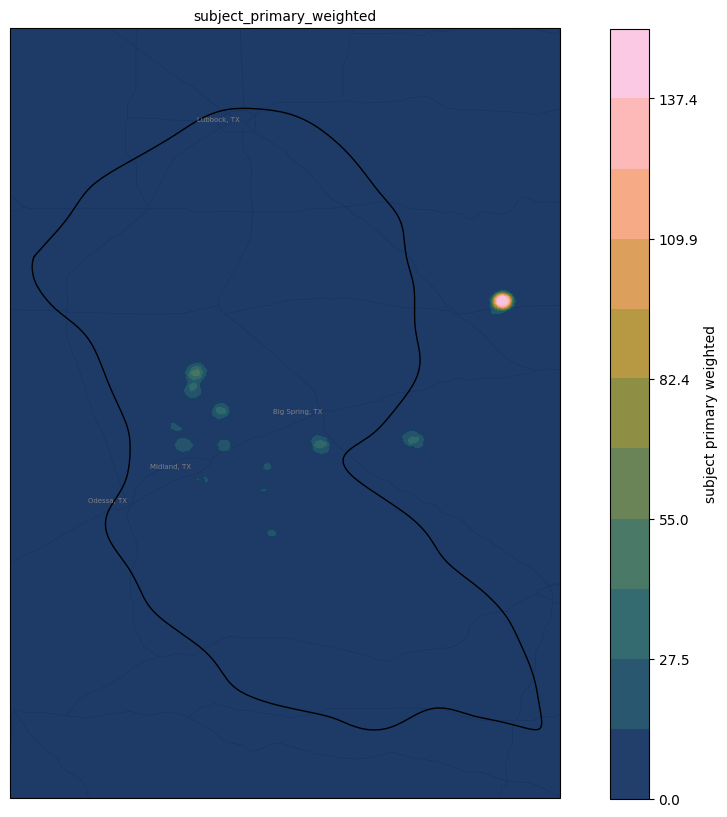

In [14]:
from seisnetinsight.legacy_maps import (
    render_legacy_contour,
    render_priority_clusters,
    LegacyMapConfig,
)
import matplotlib.pyplot as plt
%matplotlib inline
def show(fig):
    display(fig)
    plt.close(fig)

config = LegacyMapConfig(show_roads=True,
                         show_states=True,
                         show_cities=True, bna_label="Midland")
# all the figures can also use the composite_grid_df
# fig = render_legacy_contour(composite_grid_df, "subject_primary_weighted", params, config=config, bna_bytes=bna_bytes)
fig = render_legacy_contour(subject_df, "subject_primary_weighted", params, config=config, bna_bytes=bna_bytes)

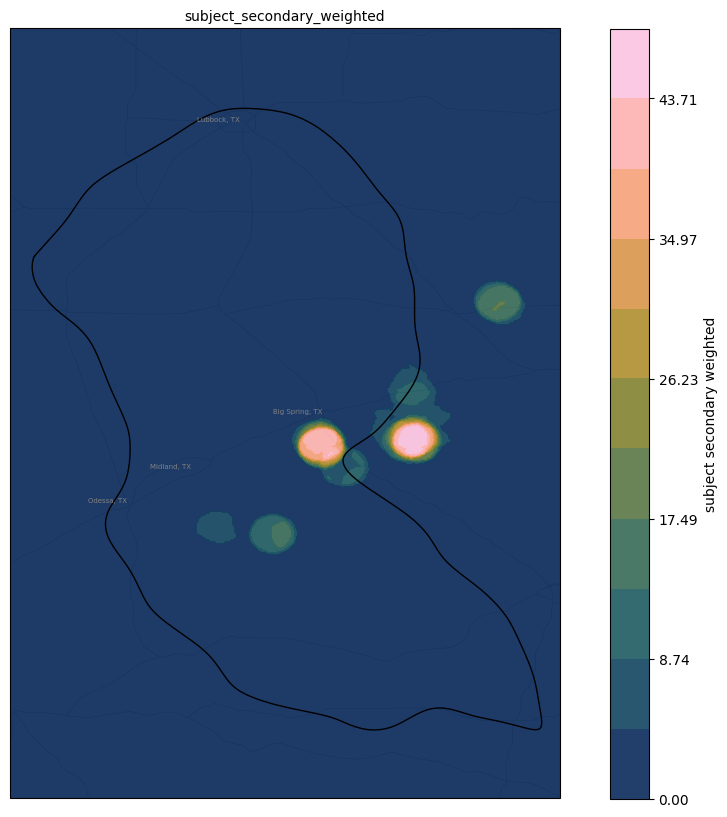

In [15]:
# all the figures can also use the composite_grid_df
# fig = render_legacy_contour(composite_grid_df, "subject_secondary_weighted", params, config=config, bna_bytes=bna_bytes)
fig = render_legacy_contour(subject_df, "subject_secondary_weighted", params, config=config, bna_bytes=bna_bytes)

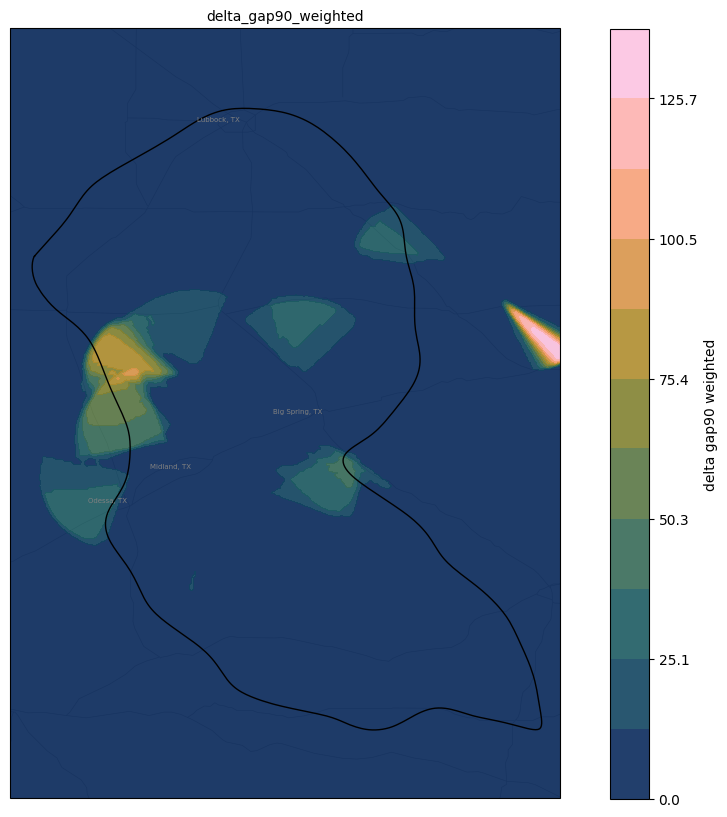

In [16]:
fig = render_legacy_contour(gap_df, "delta_gap90_weighted", params, config=config, bna_bytes=bna_bytes)

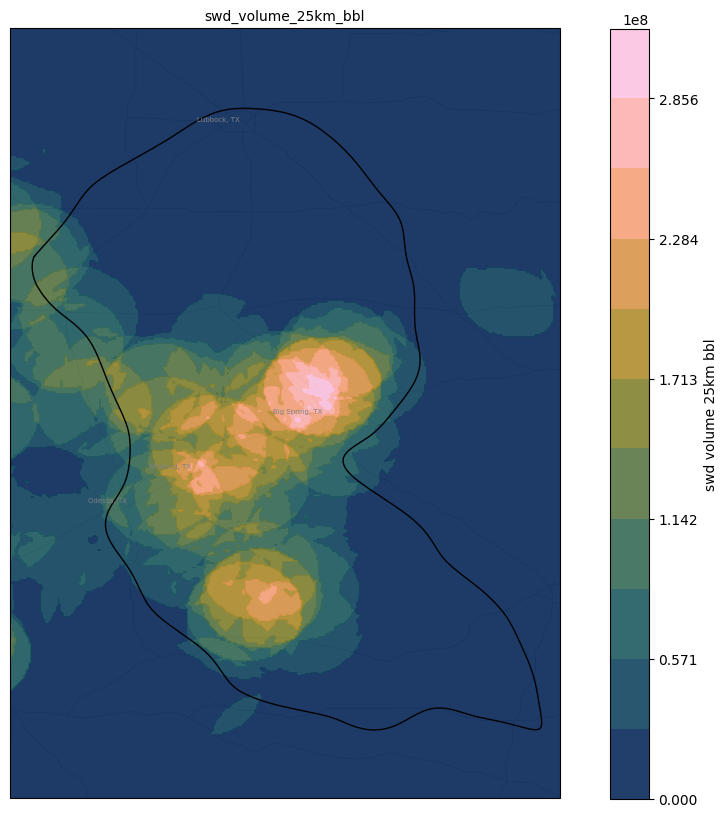

In [17]:
fig = render_legacy_contour(composite_grid_df, "swd_volume_25km_bbl", params, config=config, bna_bytes=bna_bytes)

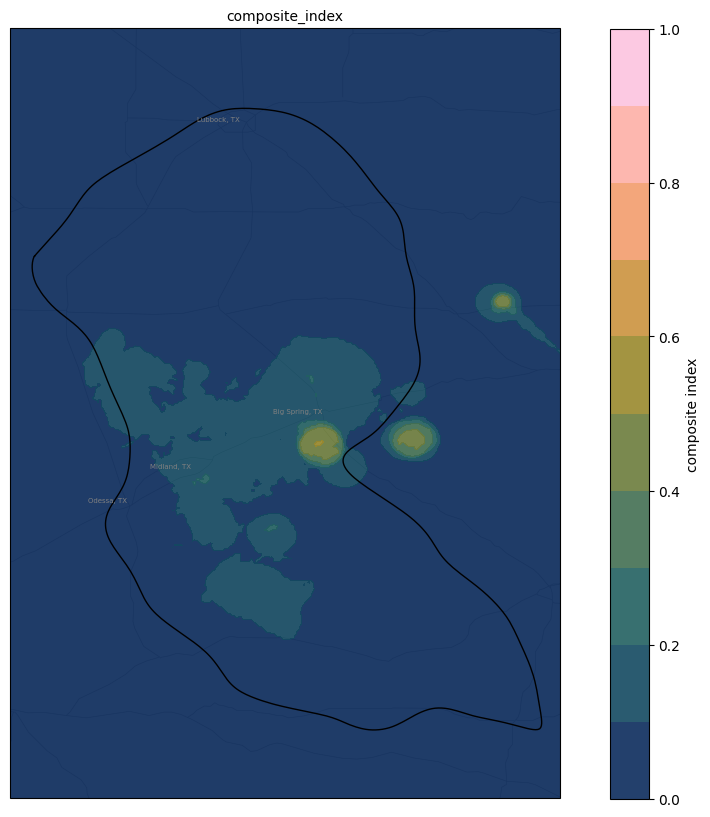

In [18]:
fig = render_legacy_contour(composite_grid_df, "composite_index", params, config=config, bna_bytes=bna_bytes)

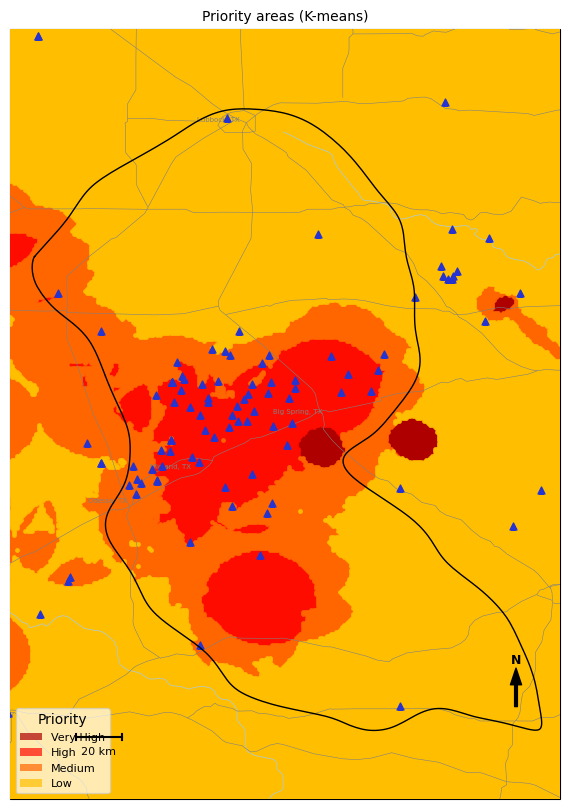

In [19]:
from seisnetinsight.maps import classify_priority_clusters

priority_df = classify_priority_clusters(
    composite_grid_df,
    features=None,          # defaults to SUBJECT_PRIMARY, SUBJECT_SECONDARY, GAP, SWD
    n_clusters=4,
    n_init=50,
    apply_feature_weights=True,
    feature_weights={
        "subject_primary_weighted": params.subject_primary_weight,
        "subject_secondary_weighted": params.subject_secondary_weight,
        "delta_gap90_weighted": params.weight_gap,
        "swd_volume_25km_bbl": params.weight_swd,
    },
)

fig = render_priority_clusters(
    priority_df,
    params,
    stations=stations_df,
    config=config,
    bna_bytes=bna_bytes,
)

In [20]:
feature_weights={
        "subject_primary_weighted": params.subject_primary_weight,
        "subject_secondary_weighted": params.subject_secondary_weight,
        "delta_gap90_weighted": params.weight_gap,
        "swd_volume_25km_bbl": params.weight_swd,
    }
feature_weights

{'subject_primary_weighted': 0.3,
 'subject_secondary_weighted': 0.4,
 'delta_gap90_weighted': 0.1,
 'swd_volume_25km_bbl': 0.2}

In [21]:
priority_df.head()

,latitude,longitude,subject_primary_count,subject_secondary_count,subject_primary_weighted,subject_secondary_weighted,delta_gap90_weighted,swd_volume_25km_bbl,composite_index,contrib_subject_primary,contrib_subject_secondary,contrib_gap,contrib_swd,priority_cluster,priority_label
0,30.5,-102.90,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Low
1,30.5,-102.89,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Low
2,30.5,-102.88,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Low
3,30.5,-102.87,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Low
4,30.5,-102.86,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Low


In [22]:
priority_df[['delta_gap90_weighted', 'composite_index']].describe()

,delta_gap90_weighted,composite_index
count,88452.000000,88452.000000
mean,3.453772,0.031546
std,11.580367,0.053443
min,0.000000,0.000000
25%,0.000000,0.000481
50%,0.000000,0.007059
75%,0.000000,0.042273
max,138.222753,0.509163


In [23]:
count = (priority_df['delta_gap90_weighted'] > 208).sum()
print(f"Number of points with delta_gap90_weighted > 208: {count}")

Number of points with delta_gap90_weighted > 208: 0


In [24]:
import seisnetinsight; print(seisnetinsight.__file__)

/home/seiscomp/test/test_seisnetinsight/version_2/SeisNetInsight/seisnetinsight/__init__.py


In [25]:
# sklearn version
import sklearn
print(f'sklearn version: {sklearn.__version__}')

sklearn version: 1.7.2


In [26]:
# python version
import sys
print(f'python version: {sys.version}')

python version: 3.12.12 | packaged by conda-forge | (main, Oct 22 2025, 23:25:55) [GCC 14.3.0]
